```@meta
CurrentModule = BayesLaplace
```

# Quick start

In [328]:
# Import libraries.
using Flux, Plots, Random, PlotThemes, Statistics, BayesLaplace
theme(:juno)
using Logging
disable_logging(Logging.Info)

LogLevel(1)

In [329]:
# Number of points to generate.
xs, y = toy_data_linear(100)
X = hcat(xs...); # bring into tabular format

In [330]:
function build_model(;input_dim=2,n_hidden=128,output_dim=1)
    
    # Params:
    W₁ = input_dim
    b₁ = n_hidden
    W₀ = n_hidden
    b₀ = output_dim
    
    nn = Chain(
        Dense(W₁, b₁, σ),
        Dense(W₀, b₀))  

    return nn

end
nn = build_model()

Chain(
  Dense(2, 128, σ),                     # 384 parameters
  Dense(128, 1),                        # 129 parameters
)                   # Total: 4 arrays, 513 parameters, 2.254 KiB.

In [331]:
nn = Chain(Dense(2,1))

Chain(
  Dense(2, 1),                          # 3 parameters
)

In [332]:
λ = 1

1

In [333]:
sqnorm(x) = sum(abs2, x)
weight_regularization(λ=λ) = 1/2 * λ^2 * sum(sqnorm, Flux.params(nn))

loss(x, y) = Flux.Losses.logitbinarycrossentropy(nn(x), y) + weight_regularization()
ps = Flux.params(nn)
data = zip(xs,y);

In [334]:
using Flux.Optimise: update!, ADAM
opt = ADAM()
epochs = 200
avg_loss(data) = mean(map(d -> loss(d[1],d[2]), data))

using Plots
anim = Animation()
plt = plot(ylim=(0,avg_loss(data)), xlim=(0,epochs), legend=false, xlab="Epoch")
avg_l = []

for epoch = 1:epochs
  for d in data
    gs = gradient(params(nn)) do
      l = loss(d...)
    end
    update!(opt, params(nn), gs)
  end
  avg_l = vcat(avg_l,avg_loss(data))
  plot!(plt, avg_l, color=1, title="Average (training) loss")
  frame(anim, plt)
end

gif(anim, "www/nn_training.gif");

![](www/nn_training.gif)

## Laplace appoximation

In [335]:
la = laplace(nn, λ=λ, subset_of_weights=:last_layer)
fit!(la, data);
p_plugin = plot_contour(X',y,la;title="Plugin",type=:plugin);
p_laplace = plot_contour(X',y,la;title="Laplace");

In [336]:
# Plot the posterior distribution with a contour plot.
plt = plot(p_plugin, p_laplace, layout=(1,2), size=(1000,400))
savefig(plt, "www/posterior_predictive.png")

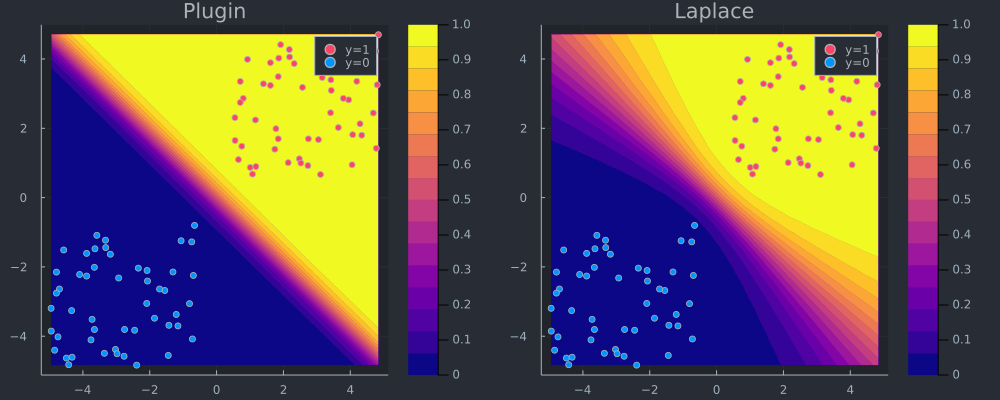

In [337]:
plt

In [338]:
la.𝐇 - la.𝐇₀

3×3 Matrix{Float64}:
  0.000105548   0.00011998   -8.08229e-5
  0.00011998    0.000145157  -0.000107322
 -8.08229e-5   -0.000107322   0.000205229

In [339]:
params(la.model)

Params([Float32[3.0120895 3.1847115], Float32[0.19360112]])